In [1]:
from unity_dataset import UnityDataset

import os

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:

NUM_EPOCHS = 3
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

PATCH_SIZE = (120, 120)

INPUT_IMAGE_DIR = "/media/blooker/Storage/gold-project-2021-images/480p/"

OUTPUT_IMAGE_DIR = "data/Data/Img"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
dataset = UnityDataset(root_dir=INPUT_IMAGE_DIR,
                       lit_folder='lit',
                       unlit_folder='unlit',
                       depth_folder='depth',
                       csv_file='pos_data.csv',
                       img_size=(480, 360),
                       patch_size=PATCH_SIZE,
                       transform=transform)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [1226939, 175277, 128])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([1164])
0.4166666666666667


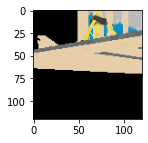

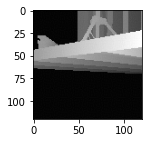

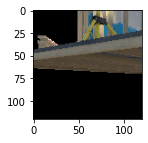

In [19]:
i = 13

plt.figure(figsize=(10,2))

x_img, x_dep, x_patch, x_pos, y = test_set[i]

print(x_pos.shape)
print(x_patch)

img = x_img.permute(1,2,0)
plt.imshow(img)

plt.figure(figsize=(10,2))

img = x_dep.permute(1,2,0)
plt.imshow(img, cmap="gray")

plt.figure(figsize=(10,2))

img = y.permute(1,2,0)
plt.imshow(img)

In [5]:

def get_device():
    # if torch.cuda.is_available():
    #     device = "cuda:0"
    # else:
    #     device = "cpu"
    # return device

    return "cuda:0"

def make_dir():
    if not os.path.exists(OUTPUT_IMAGE_DIR):
        os.makedirs(OUTPUT_IMAGE_DIR)

def save_decoded_image(img, epoch, phase):
    img = img.view(img.size(0), 3, PATCH_SIZE[0], PATCH_SIZE[1])
    path = ("./" + OUTPUT_IMAGE_DIR + "/linear_ae_image{}_{}.png").format(phase, epoch)
    save_image(img, path)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # reg encoder
        self.enc_unlit1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1)
        self.enc_unlit2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.enc_unlit3 = nn.Conv2d(in_channels=48, out_channels=32, kernel_size=3, padding=1)

        # depth encoder
        self.enc_dep1 = nn.Conv2d(in_channels=1, out_channels=36, kernel_size=3, padding=1)
        self.enc_dep2 = nn.Conv2d(in_channels=36, out_channels=36, kernel_size=3, padding=1)
        self.enc_dep3 = nn.Conv2d(in_channels=36, out_channels=24, kernel_size=3, padding=1)

        # patch encoder
        self.enc_patch1 = nn.Linear(1, 12)
        self.enc_patch2 = nn.Linear(12, 15)

        # pos encoder
        self.enc_pos1 = nn.Linear(1164, 435)

        # lit encoder
        self.enc_lit1 = nn.Conv2d(in_channels=58, out_channels=48, kernel_size=3, padding=1)
        self.enc_lit2 = nn.Conv2d(in_channels=48, out_channels=36, kernel_size=3, padding=1)

        # decoder
        self.dec1 = nn.ConvTranspose2d(in_channels=36, out_channels=36, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(in_channels=36, out_channels=48, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(in_channels=48, out_channels=3, kernel_size=2, stride=2)

    def forward(self, x_unlit, x_dep, x_patch, x_pos):

        # enc_unlit
        x_unlit = F.relu(self.enc_unlit1(x_unlit))
        x_unlit = F.max_pool2d(x_unlit, kernel_size=2, stride=2) # (b, 48, 60, 60)

        x_unlit = F.relu(self.enc_unlit2(x_unlit))
        x_unlit = F.max_pool2d(x_unlit, kernel_size=2, stride=2) # (b, 48, 30, 30)

        x_unlit = F.relu(self.enc_unlit3(x_unlit))
        x_unlit = F.max_pool2d(x_unlit, kernel_size=2, stride=2) # (b, 32, 15, 15)

        # enc_dep
        x_dep = F.relu(self.enc_dep1(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (b, 36, 60, 60)

        x_dep = F.relu(self.enc_dep2(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (b, 36, 30, 30)

        x_dep = F.relu(self.enc_dep3(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (b, 24, 15, 15)

        # enc_patch
        x_patch = F.relu(self.enc_patch1(x_patch)) # (b, 12)
        x_patch = F.relu(self.enc_patch2(x_patch)) # (b, 15)

        # enc_pos
        x_pos = F.relu(self.enc_pos1(x_pos)) # (b, 435)

        # flatten x_unlit and x_dep, concatenate together with x_patch and x_pos
        # x_unlit = torch.flatten(x_unlit, start_dim=1) # (b, 28800)
        # x_dep = torch.flatten(x_dep, start_dim=1) # (b, 21600)

        x_patch_pos = torch.cat((x_patch, x_pos), 1) # (b, 225)
        x_patch_pos = torch.reshape(x_patch_pos, (-1, 2, 15, 15))

        x_lit = torch.cat((x_patch_pos, x_unlit, x_dep), 1) # (b, 58, 15, 15)

        # lit encoder
        x_lit = F.relu(self.enc_lit1(x_lit)) # (b, 48, 15, 15)
        x_lit = F.relu(self.enc_lit2(x_lit)) # (b, 36, 15, 15)

        # decoder
        x_lit = F.relu(self.dec1(x_lit)) # (36, 30, 30)
        x_lit = F.relu(self.dec2(x_lit)) # (48, 60, 60)
        x_lit = torch.sigmoid(self.dec3(x_lit)) # (3, 120, 120)

        return x_lit

net = Autoencoder()
print(net)

Autoencoder(
  (enc_unlit1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_unlit2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_unlit3): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep1): Conv2d(1, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep2): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep3): Conv2d(36, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_patch1): Linear(in_features=1, out_features=12, bias=True)
  (enc_patch2): Linear(in_features=12, out_features=15, bias=True)
  (enc_pos1): Linear(in_features=1164, out_features=435, bias=True)
  (enc_lit1): Conv2d(58, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_lit2): Conv2d(48, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(36, 36, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(36, 48, kernel_size=(2, 2), stride=(2, 2))
  (d

In [7]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)

In [8]:
def train(net, trainloader, validloader, NUM_EPOCHS):
    train_loss = []
    valid_loss = []
    device = get_device()
    for epoch in range(NUM_EPOCHS):
        start_time = time.perf_counter()
        running_loss = 0.0

        for phase in ["train", "val"]:

            training = phase == "train"

            net.train(training)
            loader = None
            if training:
                loader = trainloader
            else:
                loader = validloader

            for data in loader:
                x, x_dep, x_patch, x_pos, y = data

                x = x.to(device, dtype=torch.float)
                x_dep = x_dep.to(device, dtype=torch.float)
                x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
                x_pos = x_pos.to(device, dtype=torch.float)
                y = y.to(device, dtype=torch.float)

                optimizer.zero_grad()
                outputs = net(x, x_dep, x_patch, x_pos)
                loss = criterion(outputs, y)

                del x, x_dep, x_patch, x_pos, y

                if training:
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

            loss = running_loss / len(loader)

            if training:
                train_loss.append(loss)
            else:
                valid_loss.append(loss)

            print("Epoch {} of {}, {} loss: {:.6f}, Time: {:.4f}".format(
                epoch+1, NUM_EPOCHS, phase, loss, time.perf_counter()-start_time
            ))

            save_decoded_image(outputs.cpu().data, epoch, phase)

        print()

    return train_loss, valid_loss

In [9]:

def test_image_reconstruction(net, testloader):
    device = get_device()
    for batch in testloader:
        x, x_dep, x_patch, x_pos, _ = batch
        x = x.to(device, dtype=torch.float)
        x_dep = x_dep.to(device, dtype=torch.float)
        x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
        x_pos = x_pos.to(device, dtype=torch.float)
        # img = img.view(img.size(0), -1)
        outputs = net(x, x_dep, x_patch, x_pos)
        outputs = outputs.view(outputs.size(0), 3, PATCH_SIZE[0], PATCH_SIZE[1]).cpu().data
        save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
        break

In [10]:

device = get_device()
print(device)

net.to(device)

make_dir()

train_loss, valid_loss = train(net, train_loader, valid_loader, NUM_EPOCHS)

cuda:0
Epoch 1 of 3, train loss: 0.013765, Time: 11725.0760
Epoch 1 of 3, val loss: 0.107862, Time: 13291.8684

Epoch 2 of 3, train loss: 0.011078, Time: 11712.0975
Epoch 2 of 3, val loss: 0.088117, Time: 13300.9845

Epoch 3 of 3, train loss: 0.010472, Time: 11813.0865
Epoch 3 of 3, val loss: 0.083484, Time: 13397.4694



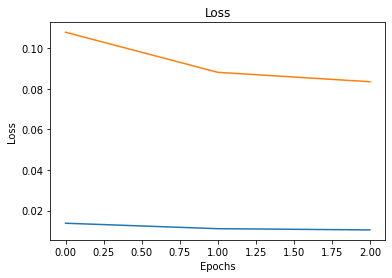

In [11]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./" + OUTPUT_IMAGE_DIR + "/deep_ae_loss.png")

In [12]:
net.to(device)
test_image_reconstruction(net, test_loader)

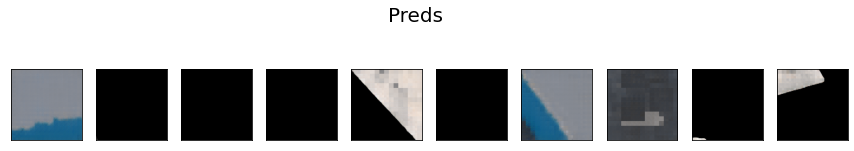

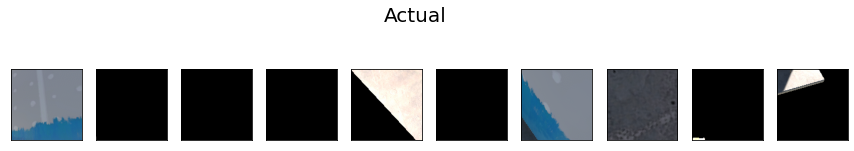

In [13]:
x_images = np.array([])
y_images = np.array([])

for batch in test_loader:
    x, x_dep, x_patch, x_pos, y = batch
    x = x.to(device, dtype=torch.float)
    x_dep = x_dep.to(device, dtype=torch.float)
    x_patch = x_patch.to(device, dtype=torch.float).unsqueeze(1)
    x_pos = x_pos.to(device, dtype=torch.float)

    # img = img.view(img.size(0), -1)
    outputs = net(x, x_dep, x_patch, x_pos)

    outputs = outputs.view(outputs.size(0), 3, PATCH_SIZE[0], PATCH_SIZE[1]).cpu().data

    y_images = y
    x_images = outputs

    save_image(x, "./" + OUTPUT_IMAGE_DIR + '/unlit.png')
    save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
    save_image(y, "./" + OUTPUT_IMAGE_DIR + '/actual.png')
    break

def show_data(X, n=10, title=""):
    plt.figure(figsize=(15,5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = X[i].permute(1,2,0)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title, fontsize=20)

show_data(x_images, title="Preds")
show_data(y_images, title="Actual")

In [14]:
# Input to the model
x = torch.randn(1, 3, PATCH_SIZE[0], PATCH_SIZE[1])
x_dep = torch.randn(1, 1, PATCH_SIZE[0], PATCH_SIZE[1])
x_patch = torch.randn(1, 1)
x_pos = torch.randn(1, 1164)

net.cpu()

# Export the model
torch.onnx.export(net,                          # model being run
                  (x, x_dep, x_patch, x_pos),   # model input (or a tuple for multiple inputs)
                  "./data/Data/model.onnx",     # where to save the model (can be a file or file-like object)
                  export_params=True,           # store the trained parameter weights inside the model file
                  opset_version=9,              # the ONNX version to export the model to
                  do_constant_folding=True,     # whether to execute constant folding for optimization
                  input_names = ['enc1'],       # the model's input names
                  output_names = ['dec3']       # the model's output names
                  )